Logger

In [31]:
import numpy as np

class Logger:
    """
    Simple logger for collecting training metrics during SAC training.
    Stores each metric as a list so they can be plotted later.
    """

    def __init__(self):
        self.data = {}

    def log(self, key, value):
        """Append a value to a specific metric key."""
        if key not in self.data:
            self.data[key] = []
        self.data[key].append(value)

    def get(self, key):
        """Return all logged values of a metric."""
        return self.data.get(key, [])

    def keys(self):
        """Return all metric names."""
        return list(self.data.keys())

    def summary(self, last_n=10):
        """Print summary of mean of the last N entries."""
        print("=== Logger Summary ===")
        for k, v in self.data.items():
            if len(v) > 0:
                print(f"{k}: mean(last {last_n}) = {np.mean(v[-last_n:]):.5f}")


In [32]:
logger = Logger()

# Example logging
for i in range(5):
    logger.log("loss_actor", np.random.random())
    logger.log("entropy", np.random.random() * 0.5)

logger.summary()


=== Logger Summary ===
loss_actor: mean(last 10) = 0.67428
entropy: mean(last 10) = 0.31487


Actor Network

In [33]:
import torch
import torch.nn as nn
from torch.distributions import Normal


class Actor(nn.Module):
    """
    Stochastic Actor Network for SAC (Gaussian Policy with Tanh Squash)
    Supports per-dimension action ranges, e.g.
    min_action = [-1, -2, -0.5]
    max_action = [ 1,  2,  1.0]
    """
    def __init__(self, state_dim, action_dim, min_action, max_action):
        super().__init__()

        # Ensure min/max are tensors with correct shape
        min_action = torch.tensor(min_action, dtype=torch.float32)
        max_action = torch.tensor(max_action, dtype=torch.float32)

        assert min_action.shape == (action_dim,)
        assert max_action.shape == (action_dim,)

        # Register as buffers (moved automatically with model.to(device))
        self.register_buffer("min_action", min_action)
        self.register_buffer("max_action", max_action)

        # Actor network
        self.net = nn.Sequential(
            nn.Linear(state_dim, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, action_dim),
        )

        # Learnable log standard deviation
        self.log_std = nn.Parameter(torch.zeros(action_dim))

        # Limit std range for stability
        self.LOG_STD_MIN = -20
        self.LOG_STD_MAX = 2

    def forward(self, state):
        """
        Returns mean and std of the Gaussian policy BEFORE tanh squash.
        """
        mean = self.net(state)

        # Clamp log_std for stability
        log_std = torch.clamp(self.log_std, self.LOG_STD_MIN, self.LOG_STD_MAX)
        std = torch.exp(log_std)

        return mean, std

    def sample(self, state):
        """
        Returns:
        - scaled action (after tanh + min/max scaling)
        - log_prob of the action (required for SAC)
        """
        mean, std = self.forward(state)
        dist = Normal(mean, std)

        # Reparameterization trick
        x_t = dist.rsample()
        y_t = torch.tanh(x_t)

        # Scale [-1,1] → [min,max]
        action = self.min_action + (y_t + 1) * 0.5 * (self.max_action - self.min_action)

        # Log probability with tanh correction
        log_prob = dist.log_prob(x_t)
        log_prob -= torch.log(1 - y_t.pow(2) + 1e-6)
        log_prob = torch.sum(log_prob, dim=1, keepdim=True)

        return action, log_prob

    def sample_deterministic(self, state):
        """
        Returns deterministic action (mean → tanh → scaled)
        """
        mean, _ = self.forward(state)
        y_t = torch.tanh(mean)

        action = self.min_action + (y_t + 1) * 0.5 * (self.max_action - self.min_action)
        return action


In [34]:
state_dim = 5
action_dim = 3
min_action = [0, 0, 0.5]
max_action = [1, 2, 1]

# สร้าง Actor
actor = Actor(state_dim, action_dim, min_action, max_action)

# ส่งไป GPU ถ้ามี
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actor.to(device)

# สร้าง dummy state เพื่อทดสอบ
state = torch.randn(1, state_dim).to(device)  # batch size 1
action, log_prob = actor.sample(state)

print("Sampled action:\n", action)
print("Log probability:\n", log_prob)

Sampled action:
 tensor([[0.1520, 1.6079, 0.6507]], device='cuda:0', grad_fn=<AddBackward0>)
Log probability:
 tensor([[-2.1592]], device='cuda:0', grad_fn=<SumBackward1>)


----------------------------------------------------------------------------------------------------------------------------------------------------------------------

Critic Network

In [35]:
import torch
import torch.nn as nn


class Critic(nn.Module):
    """
    Twin Q Network for SAC (Q1 and Q2)
    Inputs:
        state:  [batch, state_dim]
        action: [batch, action_dim]
    Output:
        q1, q2: [batch, 1]
    """
    def __init__(self, state_dim, action_dim):
        super().__init__()

        # Q1 network
        self.q1_net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

        # Q2 network
        self.q2_net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

        # Apply weight initialization
        self.apply(self._init_weights)

    def _init_weights(self, m):
        """
        Custom weight initialization for better stability.
        """
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, state, action):
        """
        Forward both Q networks.
        """
        # Ensure concatenation on correct dimension
        sa = torch.cat([state, action], dim=1)

        q1 = self.q1_net(sa)
        q2 = self.q2_net(sa)
        return q1, q2


In [36]:
state_dim = 5
action_dim = 3

critic = Critic(state_dim, action_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
critic.to(device)

# Dummy state & action
state = torch.randn(1, state_dim).to(device)  # batch size 1
action = torch.randn(1, action_dim).to(device)

q1, q2 = critic(state, action)
print("Q1:\n", q1)
print("Q2:\n", q2)


Q1:
 tensor([[0.0315]], device='cuda:0', grad_fn=<AddmmBackward0>)
Q2:
 tensor([[0.0535]], device='cuda:0', grad_fn=<AddmmBackward0>)


----------------------------------------------------------------------------------------------------------------------------------------------------------------------

Replaybuffer memory

In [37]:
import numpy as np
import torch

class Vanilla_ReplayBuffer:
    """
    Standard Replay Buffer for off-policy RL (SAC, TD3, DDPG)
    Features:
    - Fast NumPy storage
    - Tensor conversion only during sampling
    - Supports large batches efficiently
    - Works with GPU via device argument
    """
    def __init__(self, state_dim, action_dim, capacity=100000, device='cpu'):
        self.capacity = capacity
        self.device = device

        self.ptr = 0      # write pointer
        self.size = 0     # current size

        # Pre-allocate memory (fast!)
        self.state = np.zeros((capacity, state_dim), dtype=np.float32)
        self.action = np.zeros((capacity, action_dim), dtype=np.float32)
        self.reward = np.zeros((capacity, 1), dtype=np.float32)
        self.next_state = np.zeros((capacity, state_dim), dtype=np.float32)
        self.done = np.zeros((capacity, 1), dtype=np.float32)

    def push(self, s, a, r, s2, d):
        """
        Store one transition (s, a, r, s2, done)
        """
        i = self.ptr

        self.state[i] = s
        self.action[i] = a
        self.reward[i] = r
        self.next_state[i] = s2
        self.done[i] = d

        # Move pointer
        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        """
        Random sample a mini-batch.
        Returns tensors on the selected device.
        """
        idx = np.random.randint(0, self.size, size=batch_size)

        state      = torch.tensor(self.state[idx], dtype=torch.float32, device=self.device)
        action     = torch.tensor(self.action[idx], dtype=torch.float32, device=self.device)
        reward     = torch.tensor(self.reward[idx], dtype=torch.float32, device=self.device)
        next_state = torch.tensor(self.next_state[idx], dtype=torch.float32, device=self.device)
        done       = torch.tensor(self.done[idx], dtype=torch.float32, device=self.device)

        return state, action, reward, next_state, done

    def __len__(self):
        return self.size


In [38]:
state_dim = 4
action_dim = 2
buffer = Vanilla_ReplayBuffer(state_dim, action_dim, capacity=10, device='cpu')

# สร้าง dummy data
for i in range(12):  # push เกิน capacity เพื่อทดสอบ circular buffer
    s = np.random.randn(state_dim)
    a = np.random.randn(action_dim)
    r = np.random.randn(1)
    s2 = np.random.randn(state_dim)
    d = np.random.randint(0,2)
    buffer.push(s, a, r, s2, d)
    print(f"Pushed transition {i+1}, buffer size: {len(buffer)}")

# sample batch
batch_size = 5
s_batch, a_batch, r_batch, s2_batch, d_batch = buffer.sample(batch_size)

print("\nSampled states:\n", s_batch)
print("Sampled actions:\n", a_batch)
print("Sampled rewards:\n", r_batch)
print("Sampled next_states:\n", s2_batch)
print("Sampled dones:\n", d_batch)

Pushed transition 1, buffer size: 1
Pushed transition 2, buffer size: 2
Pushed transition 3, buffer size: 3
Pushed transition 4, buffer size: 4
Pushed transition 5, buffer size: 5
Pushed transition 6, buffer size: 6
Pushed transition 7, buffer size: 7
Pushed transition 8, buffer size: 8
Pushed transition 9, buffer size: 9
Pushed transition 10, buffer size: 10
Pushed transition 11, buffer size: 10
Pushed transition 12, buffer size: 10

Sampled states:
 tensor([[-1.5399, -0.9285,  0.4562,  2.0308],
        [-1.0171, -1.3294,  0.0801, -0.5136],
        [-0.4665, -1.1984, -0.8764,  1.8608],
        [-0.8584, -0.8444,  0.6677, -0.2575],
        [-1.1529,  0.9530,  1.3799,  1.0435]])
Sampled actions:
 tensor([[ 1.6858,  2.1514],
        [-1.9110,  0.8783],
        [ 1.3804,  0.0528],
        [ 0.9821, -0.5016],
        [ 0.0082, -0.3755]])
Sampled rewards:
 tensor([[ 0.6068],
        [-0.0996],
        [ 1.1831],
        [ 1.4437],
        [-0.0630]])
Sampled next_states:
 tensor([[ 1.3751, 

In [39]:
state_dim = 4
action_dim = 2
buffer = Vanilla_ReplayBuffer(state_dim, action_dim, capacity=5)

# Push 3 transitions
for i in range(3):
    buffer.push(np.random.randn(state_dim), np.random.randn(action_dim), np.random.randn(1),
                np.random.randn(state_dim), 0)
    print(f"After push {i+1}:")
    print("len(buffer):", len(buffer))
    print("buffer.__len__():", buffer.__len__())
    print("---")


After push 1:
len(buffer): 1
buffer.__len__(): 1
---
After push 2:
len(buffer): 2
buffer.__len__(): 2
---
After push 3:
len(buffer): 3
buffer.__len__(): 3
---


SAC Agent 

In [40]:
import torch
import torch.nn.functional as F

class SACAgent:
    """
    Clean & Stable SAC Agent for Jupyter Notebook.
    - Fixed alpha version (no entropy tuning)
    - Actor + Critic + Target Critic
    - Supports Vanilla Replay Buffer
    - Compatible with Logger()
    """

    def __init__(self, state_dim, action_dim, min_action, max_action, 
                 lr=3e-4, gamma=0.99, tau=0.005, alpha=0.2,
                 replay_capacity=100000,
                 device='cpu',
                 logger_status=False):
        
        # Auto device fallback
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')

        # -----------------------------
        # Networks
        # -----------------------------
        self.actor = Actor(state_dim, action_dim, min_action, max_action).to(self.device)
        self.critic = Critic(state_dim, action_dim).to(self.device)
        self.target_critic = Critic(state_dim, action_dim).to(self.device)
        self.target_critic.load_state_dict(self.critic.state_dict())

        # -----------------------------
        # Optimizers
        # -----------------------------
        self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=lr)

        # -----------------------------
        # Replay Buffer
        # -----------------------------
        self.replay_buffer = Vanilla_ReplayBuffer(
            state_dim, action_dim,
            capacity=replay_capacity,
            device=self.device
        )

        # -----------------------------
        # Hyperparameters
        # -----------------------------
        self.gamma = gamma
        self.tau = tau
        self.alpha = alpha

        # Logger (optional)
        self.logger = Logger()
        self.logger_status = logger_status

    # ---------------------------------------------------------------------
    # Action selection
    # ---------------------------------------------------------------------
    def select_action(self, state, deterministic=False):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)

        if deterministic:
            # mean → tanh → scale action
            mean, _ = self.actor.forward(state)
            y_t = torch.tanh(mean)
            action = self.actor.min_action + (y_t + 1) * 0.5 * (self.actor.max_action - self.actor.min_action)
        else:
            # reparameterized stochastic sample
            action, _ = self.actor.sample(state)

        return action.cpu().detach().numpy()[0]

    # ---------------------------------------------------------------------
    # Training update
    # ---------------------------------------------------------------------
    def update(self, batch_size=64):

        if len(self.replay_buffer) < batch_size:
            return

        # -----------------------------
        # Sample batch
        # -----------------------------
        state, action, reward, next_state, done = self.replay_buffer.sample(batch_size)
        state, action, reward, next_state, done = [
            x.to(self.device) for x in (state, action, reward, next_state, done)
        ]

        # -----------------------------
        # Target Q-value
        # -----------------------------
        with torch.no_grad():
            next_action, next_log_prob = self.actor.sample(next_state)
            q1_t, q2_t = self.target_critic(next_state, next_action)
            min_q_t = torch.min(q1_t, q2_t)

            target_q = reward + (1 - done) * self.gamma * (min_q_t - self.alpha * next_log_prob)

        # -----------------------------
        # Critic update
        # -----------------------------
        q1, q2 = self.critic(state, action)
       
        critic_loss = F.mse_loss(q1, target_q) + F.mse_loss(q2, target_q)

        self.critic_opt.zero_grad()
        critic_loss.backward()
        self.critic_opt.step()

        # -----------------------------
        # Actor update
        # -----------------------------
        a_pi, log_pi = self.actor.sample(state)
        q1_pi, q2_pi = self.critic(state, a_pi)
        q_pi = torch.min(q1_pi, q2_pi)

        actor_loss = (self.alpha * log_pi - q_pi).mean()

        self.actor_opt.zero_grad()
        actor_loss.backward()
        self.actor_opt.step()

        # -----------------------------
        # Soft update of target critic
        # -----------------------------
        for p, tp in zip(self.critic.parameters(), self.target_critic.parameters()):
            tp.data.copy_(self.tau * p.data + (1 - self.tau) * tp.data)

        # -----------------------------
        # Logging (if logger exists)
        # -----------------------------
        if self.logger_status:
            self.logger.log("loss_actor", actor_loss.item())
            self.logger.log("loss_critic", critic_loss.item())
            self.logger.log("q1_mean", q1.mean().item())
            self.logger.log("q2_mean", q2.mean().item())
            self.logger.log("entropy", -log_pi.mean().item())
            self.logger.log("alpha", self.alpha)
            self.logger.log("tau", self.tau)
            


Training loop

In [41]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# สร้าง environment
env = gym.make("Pendulum-v1")

state, _ = env.reset()
state_dim = state.shape[0]
action_dim = env.action_space.shape[0]
min_action = env.action_space.low
max_action = env.action_space.high

print("State dim:", state_dim)
print("Action dim:", action_dim)
print("Action range:", min_action, max_action)


State dim: 3
Action dim: 1
Action range: [-2.] [2.]


In [42]:


# สร้าง agent
agent = SACAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    min_action=min_action,
    max_action=max_action,
    lr=3e-4,
    gamma=0.99,
    tau=0.005,
    alpha=0.2,
    logger_status= True
)

# ===== Training Parameters =====
episodes = 50
max_steps = 200
batch_size = 64

rewards_history = []

# ===== Training Loop =====
for ep in range(episodes):

    state, _ = env.reset()
    episode_reward = 0

    for step in range(max_steps):
        # 1. เลือก action
        action = agent.select_action(state)

        # 2. Step environment
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # 3. เก็บลง Replay Buffer
        agent.replay_buffer.push(
            state, action, reward, next_state, float(done)
        )

        # 4. อัปเดต network
        agent.update(batch_size)
        
        state = next_state
        episode_reward += reward

        if done:
            break

    rewards_history.append(episode_reward)
    print(f"Episode {ep+1}/{episodes} Reward: {episode_reward:.2f}")


Episode 1/50 Reward: -1061.44
Episode 2/50 Reward: -1591.96
Episode 3/50 Reward: -1629.38
Episode 4/50 Reward: -1699.56
Episode 5/50 Reward: -1771.64
Episode 6/50 Reward: -1666.97
Episode 7/50 Reward: -1505.98
Episode 8/50 Reward: -1551.64
Episode 9/50 Reward: -1615.83
Episode 10/50 Reward: -1501.05
Episode 11/50 Reward: -1611.67
Episode 12/50 Reward: -1392.28
Episode 13/50 Reward: -1114.73
Episode 14/50 Reward: -1003.21
Episode 15/50 Reward: -817.36
Episode 16/50 Reward: -1070.33
Episode 17/50 Reward: -781.16
Episode 18/50 Reward: -1165.23
Episode 19/50 Reward: -737.80
Episode 20/50 Reward: -973.50
Episode 21/50 Reward: -1167.47
Episode 22/50 Reward: -1031.55
Episode 23/50 Reward: -1382.98
Episode 24/50 Reward: -1373.25
Episode 25/50 Reward: -1295.20
Episode 26/50 Reward: -734.37
Episode 27/50 Reward: -689.16
Episode 28/50 Reward: -588.24
Episode 29/50 Reward: -641.39
Episode 30/50 Reward: -516.86
Episode 31/50 Reward: -594.67
Episode 32/50 Reward: -262.95
Episode 33/50 Reward: -132.1

In [43]:
print("Replay buffer size:", len(agent.replay_buffer))
print("q1|q2 size: ",len(agent.logger.get("q1_mean")), len(agent.logger.get("q2_mean")))

Replay buffer size: 10000
q1|q2 size:  9937 9937


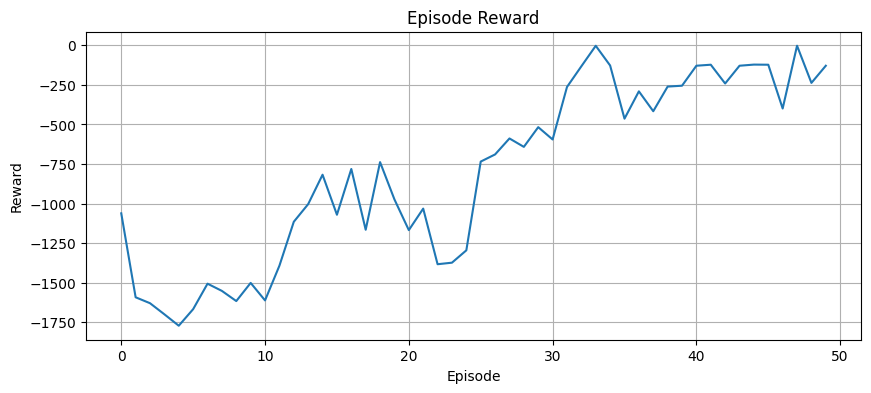

In [44]:
plt.figure(figsize=(10,4))
plt.plot(rewards_history)
plt.title("Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()


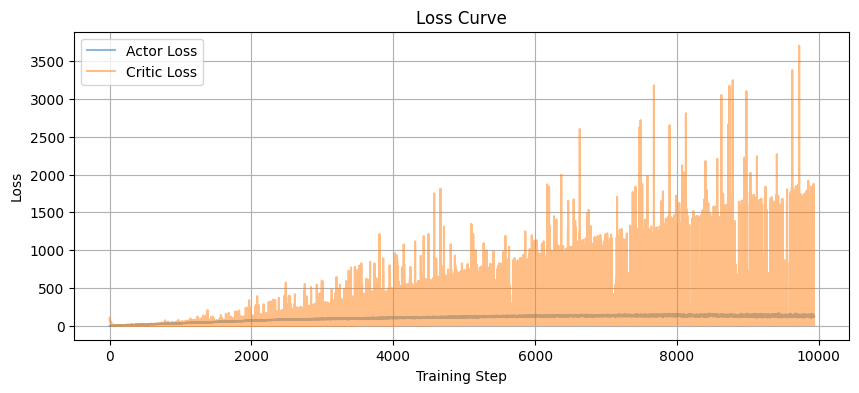

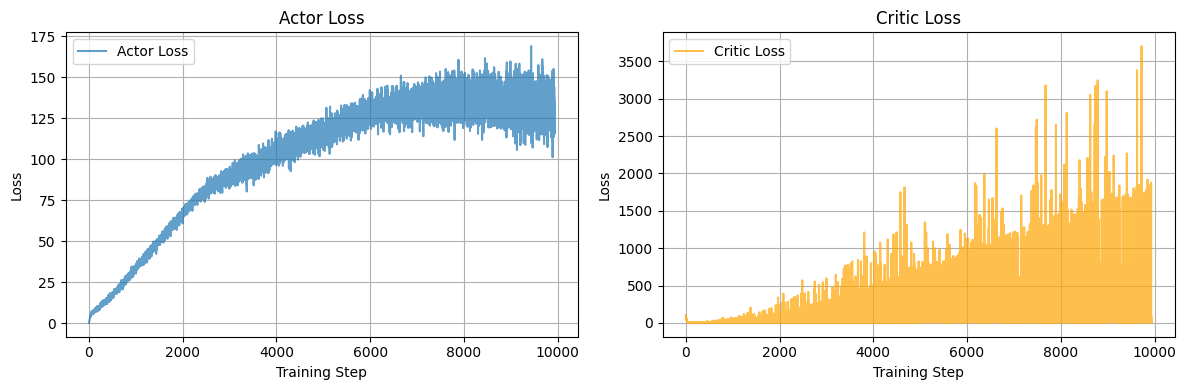

In [45]:
plt.figure(figsize=(10,4))
plt.plot(agent.logger.get("loss_actor"), label="Actor Loss",alpha=0.5)
plt.plot(agent.logger.get("loss_critic"), label="Critic Loss",alpha=0.5)
plt.title("Loss Curve")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(12,4))

# ------ Left : Actor Loss ------
plt.subplot(1, 2, 1)
plt.plot(agent.logger.get("loss_actor"), label="Actor Loss", alpha=0.7)
plt.title("Actor Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# ------ Right : Critic Loss ------
plt.subplot(1, 2, 2)
plt.plot(agent.logger.get("loss_critic"), label="Critic Loss", alpha=0.7, color="orange")
plt.title("Critic Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


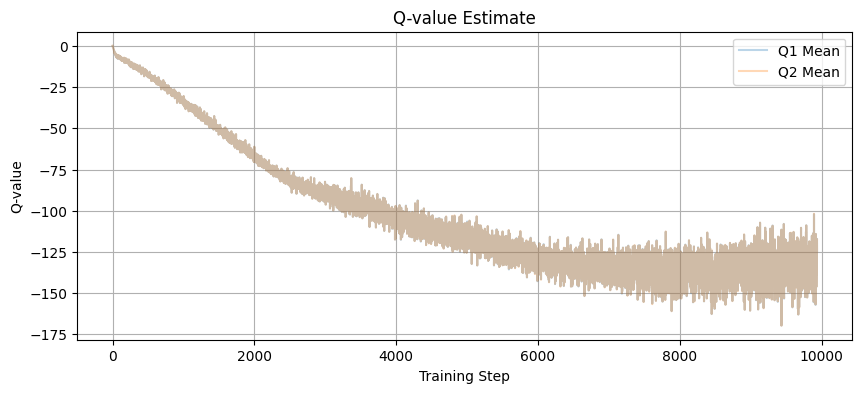

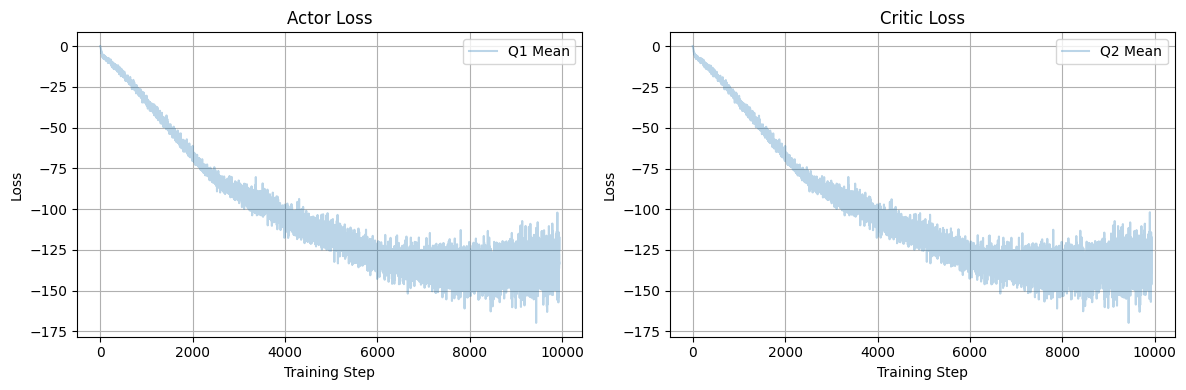

In [46]:
plt.figure(figsize=(10,4))
plt.plot(agent.logger.get("q1_mean"), label="Q1 Mean",alpha=0.3)
plt.plot(agent.logger.get("q2_mean"), label="Q2 Mean",alpha=0.3)
plt.title("Q-value Estimate")
plt.xlabel("Training Step")
plt.ylabel("Q-value")
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(12,4))

# ------ Left : Actor Loss ------
plt.subplot(1, 2, 1)
plt.plot(agent.logger.get("q1_mean"), label="Q1 Mean",alpha=0.3)
plt.title("Actor Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# ------ Right : Critic Loss ------
plt.subplot(1, 2, 2)
plt.plot(agent.logger.get("q2_mean"), label="Q2 Mean",alpha=0.3)
plt.title("Critic Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


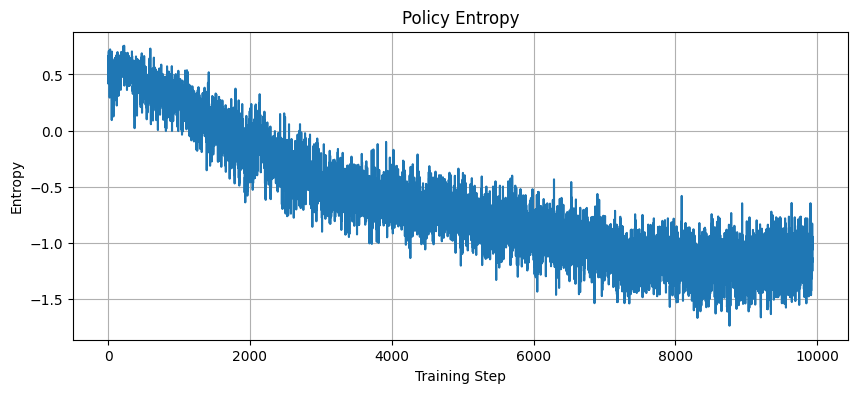

In [47]:
plt.figure(figsize=(10,4))
plt.plot(agent.logger.get("entropy"), label="Entropy")
plt.title("Policy Entropy")
plt.xlabel("Training Step")
plt.ylabel("Entropy")
plt.grid(True)
plt.show()


Test Agent

In [48]:
def test_agent(env, agent, episodes=5, max_steps=200):
    returns = []
    trajectories = []   # เก็บ state/action/reward เพื่อนำไป plot

    for ep in range(episodes):
        state, _ = env.reset()
        episode_reward = 0
        states = []
        actions = []
        rewards = []

        for step in range(max_steps):
            # ใช้ deterministic เพื่อดู performance จริง
            action = agent.select_action(state, deterministic=True)

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            # เก็บข้อมูลสำหรับ plot
            states.append(state)
            actions.append(action)
            rewards.append(reward)

            episode_reward += reward
            state = next_state

            if done:
                break

        returns.append(episode_reward)
        trajectories.append({
            "states": np.array(states),
            "actions": np.array(actions),
            "rewards": np.array(rewards),
        })

        print(f"[TEST] Episode {ep+1}/{episodes} Reward = {episode_reward:.2f}")

    return returns, trajectories


[TEST] Episode 1/5 Reward = -122.88
[TEST] Episode 2/5 Reward = -130.22
[TEST] Episode 3/5 Reward = -124.25
[TEST] Episode 4/5 Reward = -391.61
[TEST] Episode 5/5 Reward = -349.43


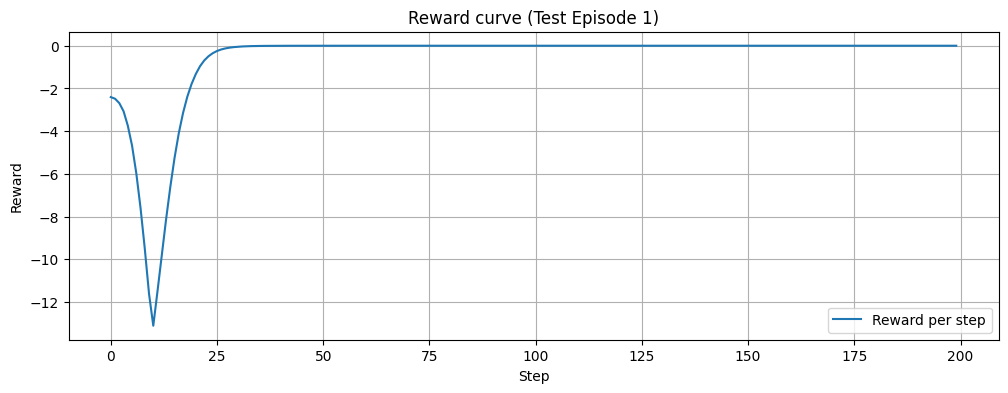

In [59]:
test_returns, test_traj = test_agent(env, agent, episodes=5, max_steps=200)
plt.figure(figsize=(12,4))
plt.plot(test_traj[2]["rewards"], label="Reward per step")
plt.title("Reward curve (Test Episode 1)")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.show()


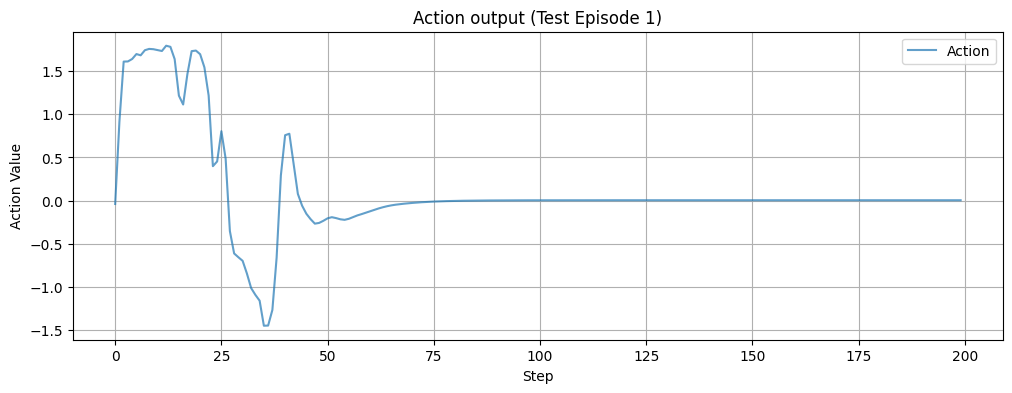

In [58]:
plt.figure(figsize=(12,4))
plt.plot(test_traj[2]["actions"], label="Action", alpha=0.7)
plt.title("Action output (Test Episode 1)")
plt.xlabel("Step")
plt.ylabel("Action Value")
plt.grid(True)
plt.legend()
plt.show()


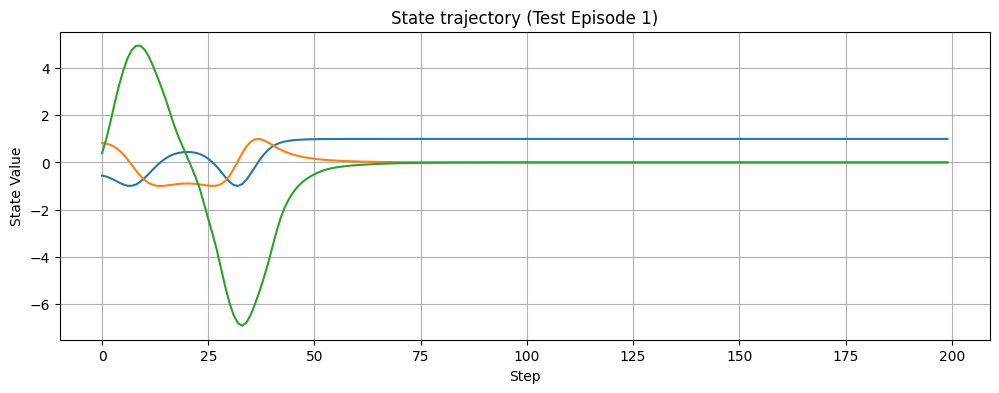

In [57]:
plt.figure(figsize=(12,4))
plt.plot(test_traj[2]["states"])
plt.title("State trajectory (Test Episode 1)")
plt.xlabel("Step")
plt.ylabel("State Value")
plt.grid(True)
plt.show()


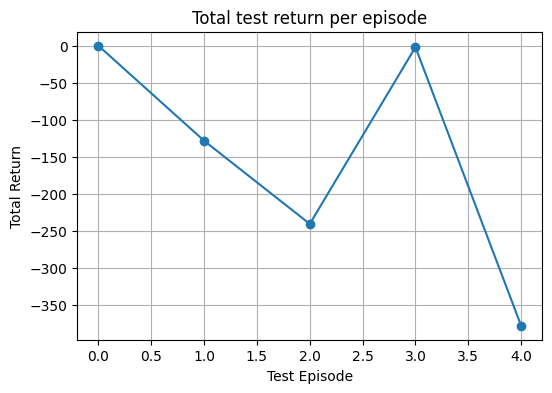

In [52]:
plt.figure(figsize=(6,4))
plt.plot(test_returns, marker="o")
plt.title("Total test return per episode")
plt.xlabel("Test Episode")
plt.ylabel("Total Return")
plt.grid(True)
plt.show()
